# Santander Product Recommendation<br>
https://www.kaggle.com/c/santander-product-recommendation

## 파생변수 생성 및 모델링

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_test = pd.read_csv('../data/santander/train_test_EDA.csv')

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
train_test['indrel_1mes'] = train_test['indrel_1mes'].astype(str)

In [5]:
train_test.shape

(14549190, 45)

In [6]:
train_test.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes',
       'tiprel_1mes', 'indresi', 'indext', 'conyuemp', 'canal_entrada',
       'indfall', 'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')

In [7]:
train_test.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,1375586,N,ES,H,35,16,0.0,6,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1050611,N,ES,V,23,45,0.0,35,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1050612,N,ES,V,23,45,0.0,35,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1050613,N,ES,H,22,45,0.0,35,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1050614,N,ES,V,23,45,0.0,35,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
idx_col = list(train_test.columns[:2])
X_col = list(train_test.columns[2:21])
y_col = list(train_test.columns[21:])

여기서 y_col 항목은 상품 보유여부를 뜻한다. <br>
그런데 우리가 원하는 데이터는 최종 17개월차에 '어떤 상품을 보유하고 있을지'가 아니라, '어떤 상품을 신규로 구매할 가능성이 가장 높은지'이다. <br>
따라서 신규 구매여부를 판단하기 위해서는 지난달 보유상태는 0이었는데 이번 달에는 1로 바뀐 상품만 필터링할 필요가 있다. 

In [9]:
idx_y_col = train_test[idx_col + y_col]
idx_y_col_copy = idx_y_col.copy()
idx_y_col_copy['fecha_dato']+=1
idx_y_col_prev = pd.merge(idx_y_col[idx_col], idx_y_col_copy, on = idx_col, how = 'left')
idx_y_col_prev = idx_y_col_prev.fillna(0)
#지난달 보유 상품 목록의 날짜 인덱스에 1을 더해서 이번 달 보유 상품 목록과 비교 가능하게 나란히 정렬

In [10]:
y_col_prev = []
for col in y_col:
    y_col_prev.append(col+'_prev')

In [11]:
for prod, prev in zip(y_col, y_col_prev):
    idx_y_col[prev] = idx_y_col_prev[prod]

<ipython-input-11-21cc3e656070>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_y_col[prev] = idx_y_col_prev[prod]


In [12]:
a, b = [],[]
for prod, prev in zip(y_col, y_col_prev):
    prX = idx_y_col[(idx_y_col[prod]==1)& (idx_y_col[prev]==0)] 
    # 각 상품별로 이번달은 1인데 지난달은 0인 row 찾기 -> 실제로 구매가 발생한 데이터만 필터링
    prY=[]
    for i in range(len(prX)):
        prY.append(prod) #필터링에 상품명을 붙이기
    a.append(prX)
    b.append(prY)
new_pur = pd.concat(a)
y = np.hstack(b)
new_pur['y'] = y
new_pur.drop(new_pur[new_pur['fecha_dato']==0].index, inplace = True)
new_pur.sort_index(inplace = True)

In [13]:
new_pur['y'].value_counts().sort_index()

ind_ahor_fin_ult1         2
ind_aval_fin_ult1         4
ind_cco_fin_ult1     163764
ind_cder_fin_ult1       141
ind_cno_fin_ult1      38181
ind_ctju_fin_ult1      1273
ind_ctma_fin_ult1      9687
ind_ctop_fin_ult1      3919
ind_ctpp_fin_ult1      2434
ind_deco_fin_ult1      5135
ind_dela_fin_ult1     13725
ind_deme_fin_ult1       250
ind_ecue_fin_ult1     26480
ind_fond_fin_ult1      3755
ind_hip_fin_ult1         75
ind_nom_pens_ult1     85737
ind_nomina_ult1       74740
ind_plan_fin_ult1       653
ind_pres_fin_ult1       151
ind_reca_fin_ult1      9305
ind_recibo_ult1      154518
ind_tjcr_fin_ult1     69770
ind_valo_fin_ult1      4929
ind_viv_fin_ult1         70
Name: y, dtype: int64

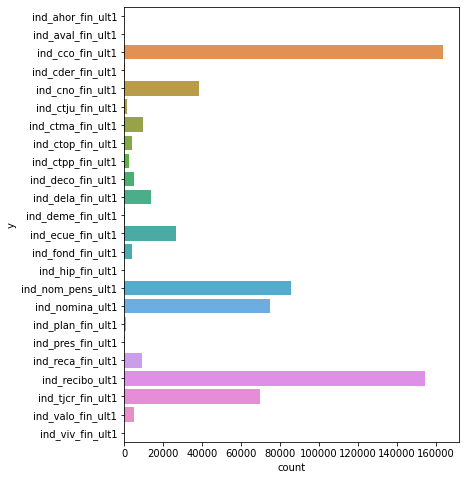

In [14]:
plt.figure(figsize = (6, 8))
sns.countplot(y = new_pur['y'].sort_values())
plt.show()

In [15]:
new_pur.shape

(668698, 51)

총 13647309개의 데이터 중에서, 실제로 구매가 발생한 데이터만 필터링한 결과 668698개로 줄어들었다. <br>
즉, 전체 데이터 중에서 약 4.9%의 데이터만 실제로 사용가능한 유용한 값이었고, 나머지는 분석에 도움이 되지 않는 더미데이터라는 것을 알 수 있었다. 

In [16]:
train_pur = train_test.loc[new_pur.index,:]

In [17]:
train_rev = pd.concat([train_pur[idx_col+X_col], new_pur[y_col_prev + ['y']]], axis = 1)

실제로 구매가 발생한 데이터의 현재 고객 정보와 지난달 보유했던 상품 목록, 새로 구매한 상품 명을 붙인다. 

grouped = new_pur.groupby(by = ['fecha_dato', 'ncodpers'])['y'].count()
grouped = grouped.reset_index().rename(columns = {'y':'total_pur'})

train_rev = pd.merge(train_rev, grouped, on = idx_col, how = 'left')

또한 한 고객이 동시에 2개 이상의 상품을 구매하는 경우도 있으므로, 구매한 상품의 갯수도 붙여준다. 

In [18]:
test_rev = pd.concat([train_test.loc[train_test['fecha_dato']==17, ['fecha_dato', 'ncodpers']+X_col], 
                      idx_y_col.loc[idx_y_col['fecha_dato'] == 17, y_col_prev]], axis = 1)

test 데이터셋도 train 데이터셋과 마찬가지로, 현재의 고객 정보와 지난달 보유했던 상품 목록을 붙여서 동일한 형태로 변환해준다. 

In [19]:
test_rev.shape

(929615, 45)

In [20]:
train_test_rev = pd.concat([train_rev, test_rev], sort = False)

In [21]:
train_test_rev.reset_index(drop = True, inplace = True)

In [22]:
train_test_rev

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_plan_fin_ult1_prev,ind_pres_fin_ult1_prev,ind_reca_fin_ult1_prev,ind_tjcr_fin_ult1_prev,ind_valo_fin_ult1_prev,ind_viv_fin_ult1_prev,ind_nomina_ult1_prev,ind_nom_pens_ult1_prev,ind_recibo_ult1_prev,y
0,1,545113,N,ES,V,48,129,0.0,9,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,ind_ecue_fin_ult1
1,1,544977,N,ES,H,25,129,0.0,120,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ind_cno_fin_ult1
2,1,544977,N,ES,H,25,129,0.0,120,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ind_nom_pens_ult1
3,1,544977,N,ES,H,25,129,0.0,120,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ind_nomina_ult1
4,1,545326,N,ES,V,58,129,0.0,119,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ind_reca_fin_ult1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598308,17,660237,N,ES,V,55,205,0.0,206,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN
1598309,17,660238,N,ES,V,30,114,0.0,115,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1598310,17,660240,N,ES,V,52,114,0.0,115,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1598311,17,660243,N,ES,V,32,114,0.0,115,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


이번 달에 무슨 상품을 구매할 지 예측하기 위해서는 바로 지난 달에 보유하고 있던 상품에 대한 데이터뿐만 아니라, 2달 전, 3달 전 보유 상품 역시 도움이 될 수 있다. 다만 이때, EDA 파트에서 보았듯이, 총 17개월간 고객의 수가 일정하지 않았고 새로 추가되거나 사라진 고객도 존재하고 있으므로, 이로 인해 발생하는 결측치는 따로 분류할 필요가 있다. 이에 해당하는 값은 결측치를 나타내는 -9로 기록한다.

In [23]:
def prev_products(i):
    idx_y_col = train_test[idx_col + y_col]
    idx_y_col_copy = idx_y_col.copy()
    idx_y_col_copy['fecha_dato']+=i
    idx_y_col_prev = pd.merge(train_test_rev[idx_col], idx_y_col_copy, on = idx_col, how = 'left')
    idx_y_col_prev.fillna(-9, inplace = True)

    y_col_prev = []
    for col in y_col:
        y_col_prev.append(col+'_prev_'+str(i))

    for prod, prev in zip(y_col, y_col_prev):
        train_test_rev[prev] = idx_y_col_prev[prod]

In [24]:
prev_products(2)
prev_products(3)
prev_products(4)
prev_products(5)

In [25]:
#train_test_rev.to_csv('../data/santander/train_test_REV.csv', index = False)

In [26]:
#train_test_rev = pd.read_csv('../data/santander/train_test_REV.csv')

결측치와 이상치를 모두 정제했으니 이제 모델을 쌓는다. 

In [27]:
con_col = ['age', 'fecha_alta', 'antiguedad', 'renta']

In [28]:
cat_col = list(train_test_rev.columns[2:])
cat_col.remove('y')

In [29]:
for i in con_col:
    cat_col.remove(i)

In [30]:
y = train_test_rev.loc[train_test_rev['y'].notnull(), 'y']

In [31]:
X_train = train_test_rev.loc[train_test_rev['fecha_dato']!=17, cat_col+con_col]
X_test = train_test_rev.loc[train_test_rev['fecha_dato']==17, cat_col+con_col]

In [32]:
y_train = y.loc[X_train.index]

In [33]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer

In [34]:
ohe = OneHotEncoder(sparse = False)
mms = MinMaxScaler()

In [35]:
ct = make_column_transformer((ohe, cat_col), (mms, con_col))

In [36]:
ct.fit(train_test_rev[cat_col + con_col])
X_train_ct = ct.transform(X_train)
X_test_ct = ct.transform(X_test)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os

In [38]:
MODEL_DIR = './santander'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

In [39]:
modelpath = './santander/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 50)

In [40]:
model = Sequential()
model.add(Dense(1000, input_dim = len(X_train_ct[0]), activation = 'relu'))
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(24, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', 
             optimizer = 'adam', 
             metrics = ['categorical_accuracy'])

In [41]:
ohe.fit(pd.DataFrame(y_train))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [42]:
model.fit(X_train_ct, ohe.transform(pd.DataFrame(y_train)), validation_split = 0.2, 
          epochs = 1000, verbose = 1, batch_size = 100000, callbacks = [early_stopping_callback, checkpointer])

Epoch 1/1000
6/6 [==============================] - ETA: 0s - loss: 2.3504 - categorical_accuracy: 0.3256
Epoch 00001: val_loss improved from inf to 1.88365, saving model to ./santander/01-1.8836.hdf5
6/6 [==============================] - 12s 2s/step - loss: 2.3504 - categorical_accuracy: 0.3256 - val_loss: 1.8836 - val_categorical_accuracy: 0.3834
Epoch 2/1000
6/6 [==============================] - ETA: 0s - loss: 1.8077 - categorical_accuracy: 0.4317
Epoch 00002: val_loss improved from 1.88365 to 1.75306, saving model to ./santander/02-1.7531.hdf5
6/6 [==============================] - 11s 2s/step - loss: 1.8077 - categorical_accuracy: 0.4317 - val_loss: 1.7531 - val_categorical_accuracy: 0.4337
Epoch 3/1000
6/6 [==============================] - ETA: 0s - loss: 1.6373 - categorical_accuracy: 0.4977
Epoch 00003: val_loss improved from 1.75306 to 1.62051, saving model to ./santander/03-1.6205.hdf5
6/6 [==============================] - 11s 2s/step - loss: 1.6373 - categorical_accurac

Epoch 25/1000
6/6 [==============================] - ETA: 0s - loss: 1.0347 - categorical_accuracy: 0.6564
Epoch 00025: val_loss improved from 1.03158 to 1.03085, saving model to ./santander/25-1.0309.hdf5
6/6 [==============================] - 11s 2s/step - loss: 1.0347 - categorical_accuracy: 0.6564 - val_loss: 1.0309 - val_categorical_accuracy: 0.6336
Epoch 26/1000
6/6 [==============================] - ETA: 0s - loss: 1.0280 - categorical_accuracy: 0.6581
Epoch 00026: val_loss did not improve from 1.03085
6/6 [==============================] - 10s 2s/step - loss: 1.0280 - categorical_accuracy: 0.6581 - val_loss: 1.0583 - val_categorical_accuracy: 0.6294
Epoch 27/1000
6/6 [==============================] - ETA: 0s - loss: 1.0217 - categorical_accuracy: 0.6587
Epoch 00027: val_loss did not improve from 1.03085
6/6 [==============================] - 10s 2s/step - loss: 1.0217 - categorical_accuracy: 0.6587 - val_loss: 1.0499 - val_categorical_accuracy: 0.6290
Epoch 28/1000
6/6 [======

Epoch 51/1000
6/6 [==============================] - ETA: 0s - loss: 0.9549 - categorical_accuracy: 0.6707
Epoch 00051: val_loss improved from 0.99406 to 0.98352, saving model to ./santander/51-0.9835.hdf5
6/6 [==============================] - 11s 2s/step - loss: 0.9549 - categorical_accuracy: 0.6707 - val_loss: 0.9835 - val_categorical_accuracy: 0.6424
Epoch 52/1000
6/6 [==============================] - ETA: 0s - loss: 0.9509 - categorical_accuracy: 0.6717
Epoch 00052: val_loss did not improve from 0.98352
6/6 [==============================] - 11s 2s/step - loss: 0.9509 - categorical_accuracy: 0.6717 - val_loss: 0.9884 - val_categorical_accuracy: 0.6414
Epoch 53/1000
6/6 [==============================] - ETA: 0s - loss: 0.9493 - categorical_accuracy: 0.6716
Epoch 00053: val_loss improved from 0.98352 to 0.97699, saving model to ./santander/53-0.9770.hdf5
6/6 [==============================] - 11s 2s/step - loss: 0.9493 - categorical_accuracy: 0.6716 - val_loss: 0.9770 - val_catego

Epoch 77/1000
6/6 [==============================] - ETA: 0s - loss: 0.9255 - categorical_accuracy: 0.6763
Epoch 00077: val_loss did not improve from 0.97370
6/6 [==============================] - 10s 2s/step - loss: 0.9255 - categorical_accuracy: 0.6763 - val_loss: 0.9772 - val_categorical_accuracy: 0.6434
Epoch 78/1000
6/6 [==============================] - ETA: 0s - loss: 0.9252 - categorical_accuracy: 0.6768
Epoch 00078: val_loss improved from 0.97370 to 0.97055, saving model to ./santander/78-0.9705.hdf5
6/6 [==============================] - 11s 2s/step - loss: 0.9252 - categorical_accuracy: 0.6768 - val_loss: 0.9705 - val_categorical_accuracy: 0.6457
Epoch 79/1000
6/6 [==============================] - ETA: 0s - loss: 0.9235 - categorical_accuracy: 0.6769
Epoch 00079: val_loss did not improve from 0.97055
6/6 [==============================] - 10s 2s/step - loss: 0.9235 - categorical_accuracy: 0.6769 - val_loss: 0.9856 - val_categorical_accuracy: 0.6393
Epoch 80/1000
6/6 [======

Epoch 103/1000
6/6 [==============================] - ETA: 0s - loss: 0.9105 - categorical_accuracy: 0.6790
Epoch 00103: val_loss did not improve from 0.96316
6/6 [==============================] - 11s 2s/step - loss: 0.9105 - categorical_accuracy: 0.6790 - val_loss: 0.9747 - val_categorical_accuracy: 0.6434
Epoch 104/1000
6/6 [==============================] - ETA: 0s - loss: 0.9124 - categorical_accuracy: 0.6784
Epoch 00104: val_loss did not improve from 0.96316
6/6 [==============================] - 11s 2s/step - loss: 0.9124 - categorical_accuracy: 0.6784 - val_loss: 0.9824 - val_categorical_accuracy: 0.6438
Epoch 105/1000
6/6 [==============================] - ETA: 0s - loss: 0.9129 - categorical_accuracy: 0.6781
Epoch 00105: val_loss did not improve from 0.96316
6/6 [==============================] - 11s 2s/step - loss: 0.9129 - categorical_accuracy: 0.6781 - val_loss: 0.9821 - val_categorical_accuracy: 0.6404
Epoch 106/1000
6/6 [==============================] - ETA: 0s - loss: 

6/6 [==============================] - ETA: 0s - loss: 0.8971 - categorical_accuracy: 0.6810
Epoch 00129: val_loss did not improve from 0.96305
6/6 [==============================] - 10s 2s/step - loss: 0.8971 - categorical_accuracy: 0.6810 - val_loss: 0.9791 - val_categorical_accuracy: 0.6420
Epoch 130/1000
6/6 [==============================] - ETA: 0s - loss: 0.8994 - categorical_accuracy: 0.6811
Epoch 00130: val_loss did not improve from 0.96305
6/6 [==============================] - 10s 2s/step - loss: 0.8994 - categorical_accuracy: 0.6811 - val_loss: 0.9631 - val_categorical_accuracy: 0.6476
Epoch 131/1000
6/6 [==============================] - ETA: 0s - loss: 0.9045 - categorical_accuracy: 0.6796
Epoch 00131: val_loss did not improve from 0.96305
6/6 [==============================] - 11s 2s/step - loss: 0.9045 - categorical_accuracy: 0.6796 - val_loss: 0.9746 - val_categorical_accuracy: 0.6435
Epoch 132/1000
6/6 [==============================] - ETA: 0s - loss: 0.9068 - catego

6/6 [==============================] - ETA: 0s - loss: 0.8847 - categorical_accuracy: 0.6842
Epoch 00155: val_loss did not improve from 0.95912
6/6 [==============================] - 11s 2s/step - loss: 0.8847 - categorical_accuracy: 0.6842 - val_loss: 0.9760 - val_categorical_accuracy: 0.6436
Epoch 156/1000
6/6 [==============================] - ETA: 0s - loss: 0.8849 - categorical_accuracy: 0.6837
Epoch 00156: val_loss did not improve from 0.95912
6/6 [==============================] - 10s 2s/step - loss: 0.8849 - categorical_accuracy: 0.6837 - val_loss: 0.9778 - val_categorical_accuracy: 0.6400
Epoch 157/1000
6/6 [==============================] - ETA: 0s - loss: 0.8869 - categorical_accuracy: 0.6829
Epoch 00157: val_loss did not improve from 0.95912
6/6 [==============================] - 10s 2s/step - loss: 0.8869 - categorical_accuracy: 0.6829 - val_loss: 0.9925 - val_categorical_accuracy: 0.6384
Epoch 158/1000
6/6 [==============================] - ETA: 0s - loss: 0.8861 - catego

Epoch 182/1000
6/6 [==============================] - ETA: 0s - loss: 0.8755 - categorical_accuracy: 0.6855
Epoch 00182: val_loss did not improve from 0.95912
6/6 [==============================] - 11s 2s/step - loss: 0.8755 - categorical_accuracy: 0.6855 - val_loss: 0.9892 - val_categorical_accuracy: 0.6410
Epoch 183/1000
6/6 [==============================] - ETA: 0s - loss: 0.8757 - categorical_accuracy: 0.6855
Epoch 00183: val_loss did not improve from 0.95912
6/6 [==============================] - 11s 2s/step - loss: 0.8757 - categorical_accuracy: 0.6855 - val_loss: 0.9775 - val_categorical_accuracy: 0.6448
Epoch 184/1000
6/6 [==============================] - ETA: 0s - loss: 0.8751 - categorical_accuracy: 0.6859
Epoch 00184: val_loss did not improve from 0.95912
6/6 [==============================] - 11s 2s/step - loss: 0.8751 - categorical_accuracy: 0.6859 - val_loss: 0.9946 - val_categorical_accuracy: 0.6366
Epoch 185/1000
6/6 [==============================] - ETA: 0s - loss: 

In [43]:
model_predict = model.predict(X_test_ct)

In [44]:
y_feature_names = [i[3:] for i in ohe.get_feature_names()]

In [45]:
y_feature_prev = [col+'_prev' for col in y_feature_names]

In [46]:
already_active = np.array(train_test_rev.loc[train_test_rev['fecha_dato']==17, y_feature_prev])

In [47]:
model_predict -= already_active

In [48]:
y_predict=[]
for i in model_predict:
    y_predict.append(y_feature_names[list(i).index(i.max())])

In [55]:
model_predict_df = pd.DataFrame({'ncodpers':train_test_rev.loc[train_test_rev['fecha_dato']==17, 'ncodpers'], 'added_products' : y_predict})
model_predict_df.sort_values('ncodpers', inplace = True)
model_predict_df

,ncodpers,added_products
668698,15889,ind_recibo_ult1
1287057,15890,ind_valo_fin_ult1
1287058,15892,ind_ctop_fin_ult1
1287059,15893,ind_cco_fin_ult1
1287060,15894,ind_cno_fin_ult1
...,...,...
976380,1553685,ind_cco_fin_ult1
976382,1553686,ind_cco_fin_ult1
976383,1553687,ind_cco_fin_ult1
976384,1553688,ind_cco_fin_ult1


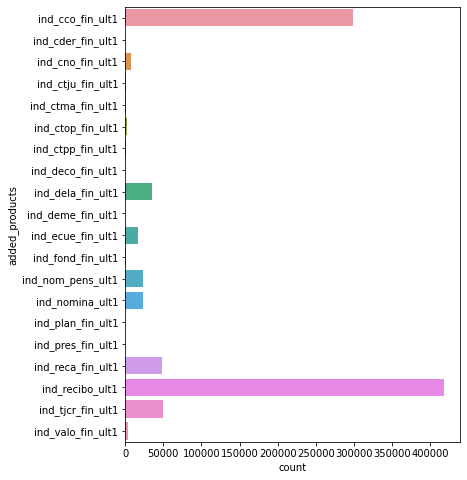

In [56]:
plt.figure(figsize = (6, 8))
sns.countplot(y = model_predict_df['added_products'].sort_values())
plt.show()

In [57]:
model_predict_df['added_products'].value_counts().sort_index()

ind_cco_fin_ult1     298461
ind_cder_fin_ult1         3
ind_cno_fin_ult1       8153
ind_ctju_fin_ult1       366
ind_ctma_fin_ult1      1130
ind_ctop_fin_ult1      2568
ind_ctpp_fin_ult1       824
ind_deco_fin_ult1        90
ind_dela_fin_ult1     34714
ind_deme_fin_ult1         2
ind_ecue_fin_ult1     16759
ind_fond_fin_ult1       746
ind_nom_pens_ult1     23043
ind_nomina_ult1       23369
ind_plan_fin_ult1        22
ind_pres_fin_ult1         4
ind_reca_fin_ult1     48171
ind_recibo_ult1      418151
ind_tjcr_fin_ult1     49940
ind_valo_fin_ult1      3099
Name: added_products, dtype: int64

In [58]:
model_predict_df.to_csv('../data/santander/submission_tensorflow.csv', index = False)

In [59]:
from PIL import Image

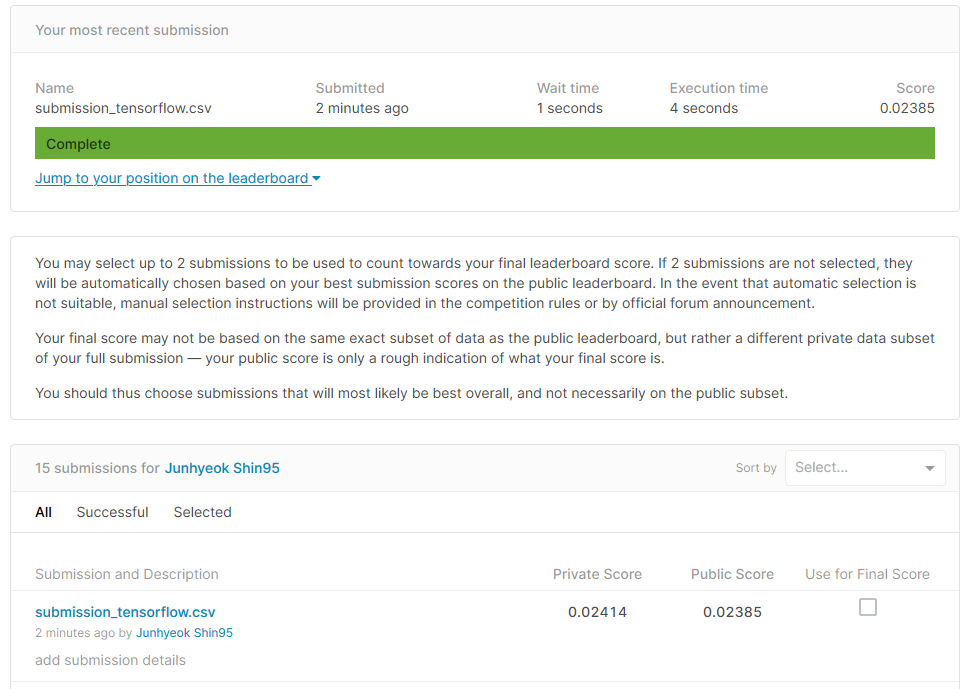

In [61]:
Image.open('../data/santander/santander_score.PNG')